In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
%cd drive/MyDrive/Colab Notebooks/STAT5242_Final_Project/

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/STAT5242_Final_Project/'
/content/drive/MyDrive/Colab Notebooks/STAT5242_Final_Project


In [65]:
from tensorflow.keras.models import Model
from matplotlib import pyplot as plt
from PIL import Image

import matplotlib.gridspec as gridspec
import tensorflow as tf
import numpy as np

tf.executing_eagerly()

True

In [66]:
def get_noise_image(content_img, seed):
    np.random.seed(seed)
    img = np.random.uniform(0, 1, content_img.shape).astype(np.float32)
    return img

def load_and_process_image(content_path, style_path):
    content_img = Image.open(content_path)
    content_img = np.array(content_img)
    content_shape = content_img.shape[:2]
    content_shape = content_shape[::-1]
    
    style_img = Image.open(style_path)
    style_img = style_img.resize(content_shape)
    style_img = np.array(style_img)
    
    return content_img, style_img


def display_result(content_path, style_path, best_img=None):
    content_img, style_img = load_and_process_image(content_path, style_path)
    
    fig = plt.figure(figsize=(13,13))
    gridspec.GridSpec(2,2)

    plt.subplot2grid((3,2), (0,0))
    plt.imshow(content_img)
    plt.title('Content Image')
    plt.axis('off')
    
    plt.subplot2grid((3,2), (0,1))
    plt.imshow(style_img)
    plt.title('Style Image')
    plt.axis('off')
    
    if best_img is not None:
        plt.subplot2grid((3,2), (1,0), colspan=2, rowspan=2)
        plt.imshow(best_img)
        plt.title('Style Transfer Output')
        plt.axis('off')

    fig.tight_layout()



In [67]:
def get_content_loss(base_content, target_content):
    return tf.reduce_mean(tf.square(base_content - target_content))


def get_style_loss(base_style, target_style):
    return tf.reduce_mean(tf.square(base_style - target_style)) 


def compute_loss(base_img, target_content, target_style, content_weight, style_weight):
    
    content_loss = 0
    style_loss = 0

    content_loss = get_content_loss(base_img, target_content)
    style_loss = get_style_loss(base_img, target_style)
        
    content_loss *= content_weight
    style_loss *= style_weight
    
    total_loss = content_loss + style_loss
    
    return total_loss, content_loss, style_loss
        

In [68]:
def compute_grad(config):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**config)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, config['base_img']), all_loss

In [83]:
def style_transfer(content_path, style_path, content_weight, style_weight, num_iterations=500):
    
    target_content, target_style = load_and_process_image(content_path, style_path)

    # base_img = tf.Variable(target_content.copy(), dtype='float')

    noise_img = get_noise_image(target_content, 100)
    base_img = tf.Variable(noise_img.copy())
    
    target_content = tf.Variable(target_content, dtype='float')
    target_style = tf.Variable(target_style, dtype='float')
    
    config = {'base_img': base_img,
              'target_content': target_content,
              'target_style': target_style,
              'content_weight': content_weight,
              'style_weight': style_weight}
    
    min_vals = 0
    max_vals = 255
    
    best_loss, best_image = float('inf'), None
    
    optim = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=0.1)

    total_loss_hist = np.zeros(num_iterations)
    
    for i in range(num_iterations):
        grad, all_loss = compute_grad(config)
        total_loss, content_loss, style_loss = all_loss
        total_loss_hist[i] = total_loss
        optim.apply_gradients([(grad, base_img)])
        clipped_img = tf.clip_by_value(base_img, min_vals, max_vals)
        base_img.assign(clipped_img)
        
        if total_loss < best_loss:
            best_loss = total_loss
            best_img = base_img.numpy()
        
    return best_loss, best_img, total_loss_hist



In [84]:
content_path = 'Image/content1.jpg'
style_path = 'Image/style1.jpg'

In [85]:
content_weight = 1e3
style_weight = 1e-2
num_iterations=1000

best_loss, best_img, total_loss_hist = style_transfer(content_path, style_path, content_weight, style_weight, num_iterations=num_iterations)

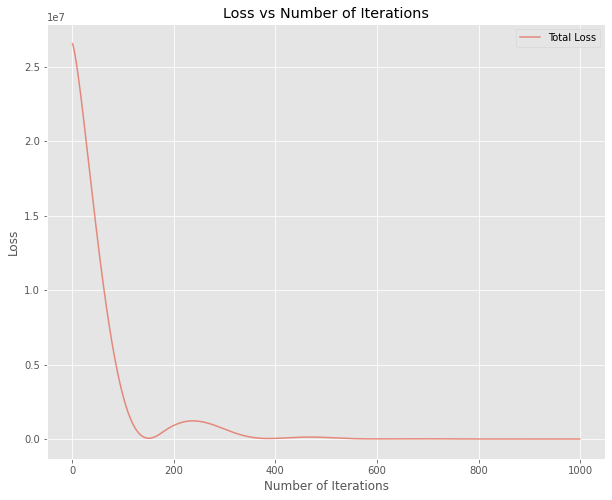

In [86]:
fig, ax = plt.subplots(figsize=(10,8))
plt.style.use('ggplot')

ax.plot(range(1,num_iterations), total_loss_hist[1:], alpha=0.6, label='Total Loss')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Number of Iterations')
plt.legend()

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


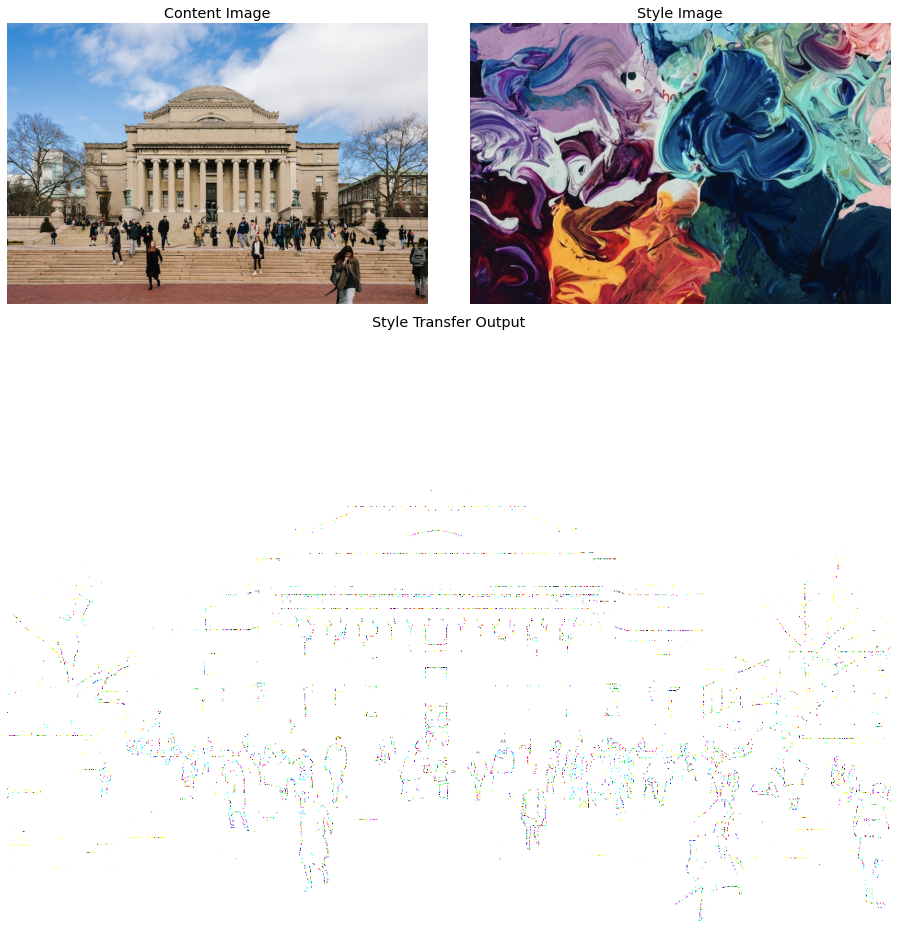

In [87]:
display_result(content_path, style_path, best_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


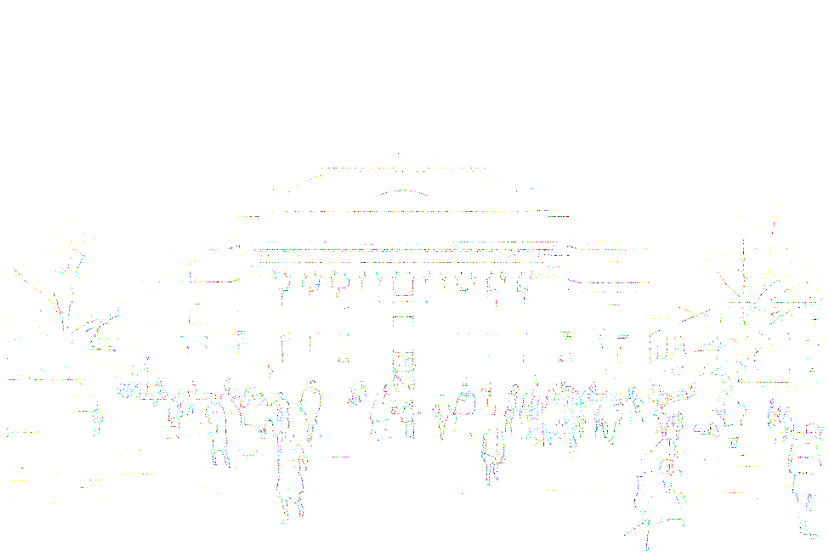

In [88]:
plt.figure(figsize=(15,10))
plt.imshow(best_img)
plt.axis('off')
plt.savefig('naive1.jpg')